# Update LSTM model

In [18]:
import pandas as pd
from matplotlib import pyplot
import seaborn as sn
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import numpy as np
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, model_from_json
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# GLOBAL 
# relh	 skph 	temp
df_train_and_test = pd.read_csv("mean_and_std")
training_mean = df_train_and_test['mean']
training_std = df_train_and_test['std']

In [123]:
# Read the CSV file - this is data from different station than this in learning module
all_data = pd.read_csv("excel_data/data_ready_for_update.csv")
all_data.drop('Unnamed: 0',axis='columns', inplace=True)
# df = all_data[(all_data['year'] == 2022) & (all_data['month'] == 12) & ((all_data['day'] == 1) | (all_data['day'] == 2))]

# only full hours
all_data = all_data[all_data['minutes'] == 0]
df = all_data[["relh", "skph", "temp"]]

In [137]:
all_data_x = all_data.copy()
all_data_x.rename(columns ={'temp':'tmpc', 'skph':'sped'}, inplace=True)
all_data_x['hour'] = pd.to_datetime(all_data['time']).dt.hour
all_data_x.drop('time',axis='columns', inplace=True)
all_data_x.insert(loc=0, column="lat", value=51)
all_data_x.insert(loc=0, column="lon", value=19)

In [139]:
all_data_x

,lon,lat,tmpc,relh,sped,day,month,year,hour
0,19,51,2.0,86.59,12.964,18,2,2020,21
1,19,51,2.0,86.59,9.260,18,2,2020,22
2,19,51,3.0,80.65,18.520,18,2,2020,23
3,19,51,3.0,80.65,12.964,19,2,2020,0
4,19,51,3.0,80.65,12.964,19,2,2020,1
...,...,...,...,...,...,...,...,...,...
25069,19,51,4.0,86.79,5.556,30,12,2022,19
25070,19,51,3.0,93.14,5.556,30,12,2022,20
25071,19,51,4.0,86.79,7.408,30,12,2022,21
25072,19,51,4.0,86.79,9.260,30,12,2022,22


In [9]:
df.head()

,relh,skph,temp
0,86.59,12.964,2.0
1,86.59,9.260,2.0
2,80.65,18.520,3.0
3,80.65,12.964,3.0
4,80.65,12.964,3.0


In [39]:
data = df.to_numpy()

In [43]:
len(data)

25074

In [45]:
data.shape

(25074, 3)

In [47]:
def standard_score(X, y, index, training_mean, training_std):
    X[:, :, index] = (X[:, :, index] - training_mean) / training_std
    y[:, index] = (y[:, index] - training_mean) / training_std


def transform_and_split_data(df_input, window_size = 6, timestamps_count = 0):
    # df = df_input.to_numpy()
    features_len = df_input.shape[1]
    data_count = len(df_input)
    X = []
    y = []
    # Explanatory X and Response y variables 
    for i in range(data_count-window_size - timestamps_count):
        row = [r for r in df_input[i:i+window_size]]
        X.append(row)
        label = [df_input[i+window_size + timestamps_count]]
        y.append(label)

    X = np.array(X)
    y = np.array(y)

    resh0 = y.shape[0]
    resh1 = y.shape[2]
    y = y.reshape(resh0, resh1)
    
    # data normalization
    for i in range(features_len):
        standard_score(X, y, i, training_mean[i], training_std[i])

    return  X, y

In [55]:
def plot_predictions_and_actual(pred, actual, start=0, end=48):

  fig, axs = plt.subplots(3)
  fig.suptitle('Weather parameters - red means predicted')
  fig.tight_layout(pad=1.8)
  axs[0].plot(pred[0][start:end],'r')
  axs[0].plot(actual[0][start:end])
  axs[0].set_title('relative humidity')

  axs[1].plot(pred[1][start:end],'r')
  axs[1].plot(actual[1][start:end])
  axs[1].set_title('speed of wind')

  axs[2].plot(pred[2][start:end],'r')
  axs[2].plot(actual[2][start:end])
  axs[2].set_title('temperature')

In [170]:
def denormalization(y, training_mean, training_std):
  y = (y*training_std) + training_mean
  return y

def update_and_predict(LSTM_model, df_input, window_size = 6, timestamps_count = 0, learning_rate = 0.001, epochs = 10, size_of_timestamps = 168, how_many_updates = 10, is_update = True): # (size_of_timestamps = 168) == 7 days
 
    MAE_humid = []
    MAE_wind = []
    MAE_temp = []

    data = df_input.to_numpy()
    # LSTM_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate= learning_rate), metrics=[RootMeanSquaredError()])
    for update in range(how_many_updates):
        data_patch_update = data[update * size_of_timestamps: (update+1) * size_of_timestamps + window_size + timestamps_count]
        X, y = transform_and_split_data(data_patch_update, window_size, timestamps_count)
        data_patch_test = data[(update+1) * size_of_timestamps : (update+2) * size_of_timestamps + window_size + timestamps_count]
        X_test, y_test = transform_and_split_data(data_patch_test, window_size, timestamps_count)

        # # update model with new data
        if(is_update):
            LSTM_model.fit(X, y,  epochs=epochs, shuffle=False)
            LSTM_model.reset_states()

        # # make predictions
        predictions = LSTM_model.predict(X_test)

        pred = []
        actual =[]
        features_len = y.shape[1]
        for i in range(features_len):
            pred.append(denormalization(predictions[:,i], training_mean[i], training_std[i]))
            actual.append(denormalization(y_test[:,i], training_mean[i], training_std[i]))
        # plot_predictions_and_actual(pred, actual)
        MAE_humid.append(mean_absolute_error(actual[0], pred[0]))
        MAE_wind.append(mean_absolute_error(actual[1], pred[1]))
        MAE_temp.append(mean_absolute_error(actual[2], pred[2]))

    # note: pred and actual are not normalized!
    return MAE_humid, MAE_wind, MAE_temp #, pred, actual


In [177]:
model = pickle.load(open("lstm12_3.pkl", "rb", -1))
MAE_humid, MAE_wind, MAE_temp = update_and_predict(model, df, 24, 5, 0.001, 5, 168, 140, True)

Epoch 1/5
6/6 [==============================] - 1s 15ms/step - loss: 0.7470 - root_mean_squared_error: 0.8643
Epoch 2/5
6/6 [==============================] - 0s 10ms/step - loss: 0.6532 - root_mean_squared_error: 0.8082
Epoch 3/5
6/6 [==============================] - 0s 9ms/step - loss: 0.5754 - root_mean_squared_error: 0.7585
Epoch 4/5
6/6 [==============================] - 0s 12ms/step - loss: 0.5483 - root_mean_squared_error: 0.7405
Epoch 5/5
6/6 [==============================] - 0s 7ms/step
Epoch 1/5
6/6 [==============================] - 0s 10ms/step - loss: 0.5249 - root_mean_squared_error: 0.7245
Epoch 2/5
6/6 [==============================] - 0s 12ms/step - loss: 0.4333 - root_mean_squared_error: 0.6582
Epoch 3/5
6/6 [==============================] - 0s 10ms/step - loss: 0.4065 - root_mean_squared_error: 0.6376
Epoch 4/5
6/6 [==============================] - 0s 9ms/step - loss: 0.3725 - root_mean_squared_error: 0.6103
Epoch 5/5
6/6 [==============================] - 0s 8

In [174]:
model = pickle.load(open("lstm12_3.pkl", "rb", -1))
MAE_humid_nu, MAE_wind_nu, MAE_temp_nu = update_and_predict(model, df, 24, 2, 0.001, 5, 168, 140, False)

6/6 [==============================] - 0s 5ms/step


In [179]:
print(np.mean(MAE_temp_nu))
print(np.mean(MAE_temp))

1.2808815907661604
2.0716178861807806


# xGBoost

In [143]:
def predict(xGBoost_model, df_input, window_size = 6, timestamps_count = 1, size_of_timestamps = 168, how_many_updates = 10): # (size_of_timestamps = 168) == 7 days
 
    MAE_humid = []
    MAE_wind = []
    MAE_temp = []

    # data = df_input.to_numpy()
    for update in range(how_many_updates):
        # data_patch_update = data[update * size_of_timestamps: (update+1) * size_of_timestamps + window_size + timestamps_count]
        # X, y = transform_and_split_data(data_patch_update, window_size, timestamps_count)
        data_patch_test = df_input[(update+1) * size_of_timestamps + window_size - 1: (update+2) * size_of_timestamps + window_size + timestamps_count]
        X_test = data_patch_test[:-timestamps_count]
        y_test = data_patch_test[timestamps_count:]

        # # update model with new data
        y_pred_xgb = xGBoost_model.predict(X_test)
        y_pred_xgb = pd.DataFrame(y_pred_xgb, columns=[ "lon", "lat",  "tmpc",  "relh" ,"sped" ,"day","month", "year", "hour"])

        # plot_predictions_and_actual(pred, actual)
        MAE_humid.append(mean_absolute_error(y_pred_xgb[["relh"]],y_test[["relh"]]))
        MAE_wind.append(mean_absolute_error(y_pred_xgb[["sped"]],y_test[["sped"]]))
        MAE_temp.append(mean_absolute_error(y_pred_xgb[["tmpc"]],y_test[["tmpc"]]))

    # note: pred and actual are not normalized!
    return MAE_humid, MAE_wind, MAE_temp #, pred, actual

In [151]:
model_x = pickle.load(open("xgb3.pkl", "rb", -1))
MAE_humid_x, MAE_wind_x, MAE_temp_x = predict(model_x, all_data_x, 6, 3, 168, 140)

Text(0.5, 1.0, 'temp')

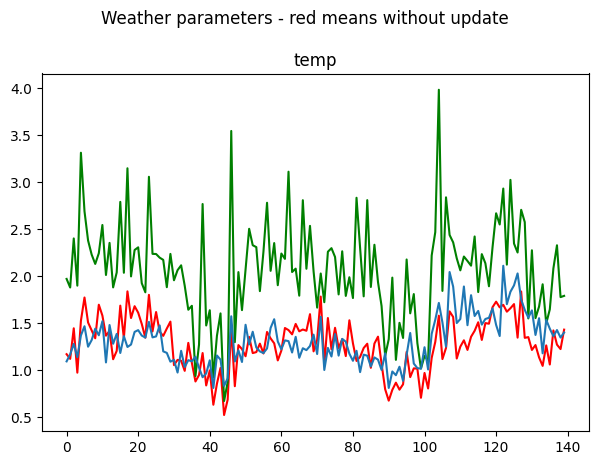

In [180]:
fig, axs = plt.subplots(1)
fig.suptitle('Weather parameters - red means without update')
fig.tight_layout(pad=1.8)
axs.plot(MAE_temp_nu,'r')
axs.plot(MAE_temp,'g')
axs.plot(MAE_temp_x)
axs.set_title('temp')

# NOTES

In [ ]:
# MSE calculations for given window size and etc. in next 1 to 5 next hours
# data to manipulate
window_size = 6
# input_count = 10
epochs = 1
learning_rate=0.01

def return_time(window_size, learning_rate, epochs):
    MSE = []
    last_pred_hour = 5
    for hour in range(last_pred_hour):
        # load json and create model
        file_name = "LSTM_model" + str(hour) + ".json"
        model_name = "LSTM_model" + str(hour) + ".h5"
        json_file = open(file_name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        LSTM_model = model_from_json(loaded_model_json)
        # load weights into new model
        LSTM_model.load_weights(model_name)

        LSTM_model, pred, actual = update_and_predict(LSTM_model, window_size, hour, learning_rate, epochs)


        shape0 = np.array(pred).shape[0]
        shape2 = np.array(pred).shape[2]

        pred = np.array(pred).reshape(shape0,shape2)
        actual = np.array(actual).reshape(shape0,shape2)

        pred =   denormalization(pred, training_mean, training_std)
        actual = denormalization(actual, training_mean, training_std)
        

        MSE.append(mean_squared_error(actual[:,2], pred[:,2]))

    return  MSE

MSE  = return_time(window_size, learning_rate, epochs)